In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import gc

plt.rcParams['figure.figsize'] = [15, 10]



Using TensorFlow backend.


In [ ]:
# Reading from NY2 dataset
dataset_file = "C:\\Users\\Avell\\Desktop\\ITA\\Tese mestrado\\robo\\NY2.mat" # Windows
#dataset_file = "/home/lmariga/githubp/datasets/NY2.mat"

f = h5py.File(dataset_file, 'r')
images = np.array(f.get('images')).T
labels = np.array(f.get('labels'), dtype=np.uint16).T
print(images.shape)
print(labels.shape)
print(f.keys())
plt.subplot(2, 2, 1)
plt.title('RGB')
plt.imshow(images[:,:,:,0])
plt.subplot(2, 2, 2)
plt.title('Labels')
plt.imshow(labels[:,:,0])
plt.subplot(2, 2, 3)
plt.title('RGB')
plt.imshow(images[:,:,:,4])
plt.subplot(2, 2, 4)
plt.title('Labels')
plt.imshow(labels[:,:,4])
plt.show()

In [2]:
# We take the labels list
data = []
for column in f['names']:
        row_data = []
        for row_number in range(len(column)):            
            row_data.append(''.join(map(chr, f[column[row_number]][:])))   
        data.append(row_data)
listanomes = data[0]

print(listanomes)


['book', 'bottle', 'cabinet', 'ceiling', 'chair', 'cone', 'counter', 'dishwasher', 'faucet', 'fire extinguisher', 'floor', 'garbage bin', 'microwave', 'paper towel dispenser', 'paper', 'pot', 'refridgerator', 'stove burner', 'table', 'unknown', 'wall', 'bowl', 'magnet', 'sink', 'air vent', 'box', 'door knob', 'door', 'scissor', 'tape dispenser', 'telephone cord', 'telephone', 'track light', 'cork board', 'cup', 'desk', 'laptop', 'air duct', 'basket', 'camera', 'pipe', 'shelves', 'stacked chairs', 'styrofoam object', 'whiteboard', 'computer', 'keyboard', 'ladder', 'monitor', 'stand', 'bar', 'motion camera', 'projector screen', 'speaker', 'bag', 'clock', 'green screen', 'mantel', 'window', 'ball', 'hole puncher', 'light', 'manilla envelope', 'picture', 'mail shelf', 'printer', 'stapler', 'fax machine', 'folder', 'jar', 'magazine', 'ruler', 'cable modem', 'fan', 'file', 'hand sanitizer', 'paper rack', 'vase', 'air conditioner', 'blinds', 'flower', 'plant', 'sofa', 'stereo', 'books', 'exit

In [3]:
# We can select the classes we want
class_floor = ['floor']
class_verticalPlanes = ['wall']
class_ceiling = ['ceiling']
class_structures = ['cabinet', 'refridgerator', 'table', 'door', 'desk', 'shelves', 'stacked chairs', 'whiteboard', 'window', 'bookshelf', 'column', 'wall divider', 'curtain'] # doors, windows, and other things that usually does not move

class_big_object = ['chair', 'cone', 'fire extinguisher', 'garbage bin', 'microwave', 'box', 'laptop', 'basket', 'computer', 'keyboard', 'monitor', 'ball', 'printer', 'fax machine','backpack']
class_small_object = ['book', 'bottle', 'paper', 'pot', 'bowl', 'scissor', 'cup', 'camera', 'bag', 'clock', 'picture', 'books', 'eraser', 'pencil holder', 'mouse', 'paper cutter', 'tape', 'circuit breaker box', 'paper towel', 'stamp','telephone', 'wire', 'head phones', 'mug holder', 'envelopes']

allowed_labels = class_verticalPlanes#+class_floor + class_ceiling + class_structures + class_big_object + class_small_object

# Finding indexes
allowed_labels_indexes = []
for i in allowed_labels: 
    allowed_labels_indexes.append(listanomes.index(i))

print(allowed_labels)
print(len(allowed_labels))
print(allowed_labels_indexes)

['wall']
1
[20]


In [4]:
# Exclui labels não usadas para treinar
labelsFinal = labels.astype(np.uint16, copy=False)
super_threshold_indices = np.isin(labelsFinal, np.asarray(allowed_labels_indexes)+1, invert=True)
labelsFinal[super_threshold_indices] = 0
super_threshold_indices = None
print(np.min(labelsFinal))

0


In [5]:
gc.collect()
# Cria nova ordem numérica para as labels [1, 2, 3 ....]
def replace_with_dict2_generic(ar, dic, assume_all_present=0):
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    ks = k[sidx]
    vs = v[sidx]
    idx = np.searchsorted(ks,ar)

    if assume_all_present==0:
        idx[idx==len(vs)] = 0
        mask = ks[idx] == ar
        return np.where(mask, vs[idx], ar)
    else:
        return vs[idx]
dictrans = {}
for i in range(len(allowed_labels_indexes)): 
    dictrans[allowed_labels_indexes[i]+1] = i+1
    

labelsFinal = replace_with_dict2_generic(labelsFinal, dictrans, False)
print(dictrans)
print(allowed_labels)

{21: 1}
['wall']


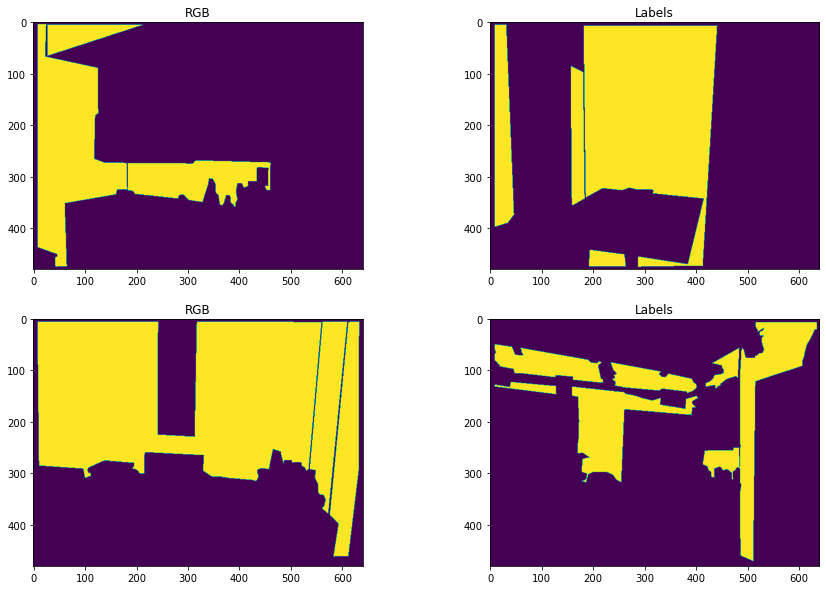

In [7]:
plt.subplot(2, 2, 1)
plt.title('RGB')
plt.imshow(labelsFinal[:,:,1])
plt.subplot(2, 2, 2)
plt.title('Labels')
plt.imshow(labelsFinal[:,:,2])
plt.subplot(2, 2, 3)
plt.title('RGB')
plt.imshow(labelsFinal[:,:,3])
plt.subplot(2, 2, 4)
plt.title('Labels')
plt.imshow(labelsFinal[:,:,4])
plt.show()

In [11]:
# Save array in a h5file
images = np.array(f.get('images')).T
h5f = h5py.File('C:\\Users\\Avell\\Desktop\\ITA\\Tese mestrado\\robo\\filtered_labels.h5', 'w')
h5f.create_dataset('labels', data=labelsFinal)
h5f.create_dataset('images', data=images)
h5f.close()

# PART 2 

In [2]:
# Reading files
dataset_file = "C:\\Users\\Avell\\Desktop\\ITA\\Tese mestrado\\robo\\filtered_labels.h5" # Windows
#dataset_file = "/home/lmariga/githubp/datasets/NY2.mat"

f = h5py.File(dataset_file, 'r')
images = np.array(f.get('images'))
print(images.shape)
images = np.moveaxis(images, -1, 0)
labels = np.array(f.get('labels'), dtype=np.uint16)
print(labels.shape)
labels = np.moveaxis(labels, -1, 0)
labels = np.expand_dims(labels, axis=-1)
print(images.shape)
print(labels.shape)

(480, 640, 3, 1449)
(480, 640, 1449)
(1449, 480, 640, 3)
(1449, 480, 640, 1)


## PREPARING THE U-NET

In [3]:


def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, nclasses=1, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(nclasses, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Number of classes
num_classes = np.max(labels)
print(num_classes)

# Percentage of images used in validation step
pecentage_test = 0.8
divIndex = int(round(labels.shape[0]*pecentage_test))
images_train = images[ 0:divIndex, :, :, :]
images_valid = images[divIndex:, :, :, :]
label_train = labels[0:divIndex, :, :]
label_valid = labels[divIndex:,:, :]
print(images_train.shape)
print(images_valid.shape)

input_img = Input(images_train.shape[1:], name='img')
unet = get_unet(input_img)
unet.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
unet.summary()

1
(1159, 480, 640, 3)
(290, 480, 640, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 480, 640, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 480, 640, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 480, 640, 16) 0           batch_normalization_2[0][0]      
___________________________________________________

In [4]:
print(images_train.shape)
print(label_train.shape)
print(images_valid.shape)
print(label_valid.shape)

(1159, 480, 640, 3)
(1159, 480, 640, 1)
(290, 480, 640, 3)
(290, 480, 640, 1)


In [8]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = unet.fit(images_train, label_train, batch_size=8, epochs=100, callbacks=callbacks,
                    validation_data=(images_valid, label_valid))

Train on 1159 samples, validate on 290 samples
Epoch 1/100
1159/1159 [==============================] - 128s 110ms/step - loss: 0.4641 - accuracy: 0.7773 - val_loss: 0.4010 - val_accuracy: 0.7938

Epoch 00001: val_loss improved from inf to 0.40102, saving model to model-tgs-salt.h5
Epoch 2/100
1159/1159 [==============================] - 123s 106ms/step - loss: 0.3778 - accuracy: 0.8282 - val_loss: 0.5716 - val_accuracy: 0.7034

Epoch 00002: val_loss did not improve from 0.40102
Epoch 3/100
1159/1159 [==============================] - 122s 106ms/step - loss: 0.3633 - accuracy: 0.8360 - val_loss: 0.3378 - val_accuracy: 0.8565

Epoch 00003: val_loss improved from 0.40102 to 0.33782, saving model to model-tgs-salt.h5
Epoch 4/100
1159/1159 [==============================] - 124s 107ms/step - loss: 0.3604 - accuracy: 0.8378 - val_loss: 0.3232 - val_accuracy: 0.8569

Epoch 00004: val_loss improved from 0.33782 to 0.32317, saving model to model-tgs-salt.h5
Epoch 5/100
1159/1159 [=============

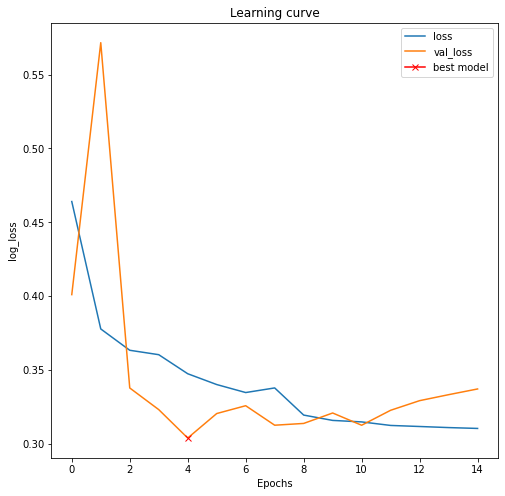

In [9]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
unet.save("rgb_nyu2_v1_model.h5")

## PARTE 3

In [5]:
# Load best model

# RGB only v1
unet = load_model("rgb_nyu2_v1_model.h5")
unet.load_weights('rgb_nyu2_v1.h5')



# Reading files
dataset_file = "C:\\Users\\Avell\\Desktop\\ITA\\Tese mestrado\\robo\\filtered_labels.h5" # Windows
#dataset_file = "/home/lmariga/githubp/datasets/NY2.mat"

f = h5py.File(dataset_file, 'r')
images = np.array(f.get('images'))
print(images.shape)
images = np.moveaxis(images, -1, 0)
labels = np.array(f.get('labels'), dtype=np.uint16)
print(labels.shape)
labels = np.moveaxis(labels, -1, 0)
labels = np.expand_dims(labels, axis=-1)
print(images.shape)
print(labels.shape)

(480, 640, 3, 1449)
(480, 640, 1449)
(1449, 480, 640, 3)
(1449, 480, 640, 1)


In [6]:
# Evaluate on validation set (this must be equals to the best log_loss)
unet.evaluate(images, labels, verbose=1)

1449/1449 [==============================] - 57s 39ms/step


[0.33027471514551127, 0.8528120517730713]

In [7]:
# Predict on train, val and test
preds_train = unet.predict(images, verbose=1)
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)

1449/1449 [==============================] - 47s 33ms/step


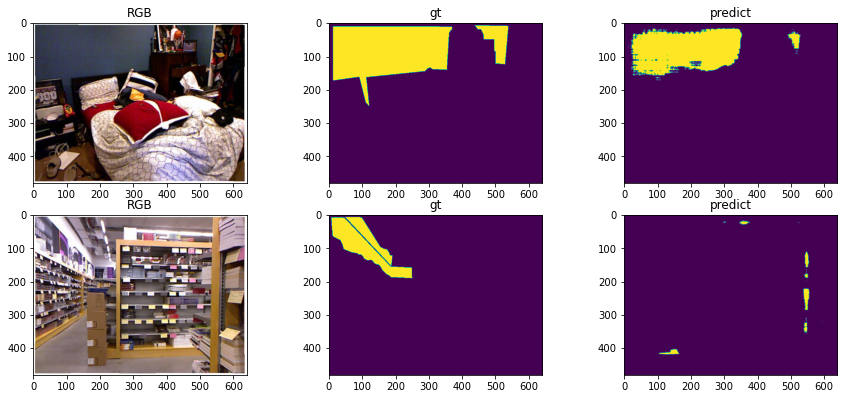

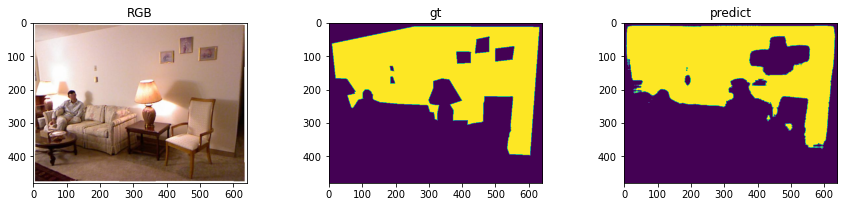

In [9]:
import random
i1 = random.randint(0, 1159)
i2 = random.randint(0, 1159)
i3 = random.randint(0, 1159)
plt.subplot(3, 3, 1)
plt.title('RGB')
plt.imshow(images[i1,:,:])
plt.subplot(3, 3, 2)
plt.title('gt')
plt.imshow(labels[i1,:,:])
plt.subplot(3, 3, 3)
plt.title('predict')
plt.imshow(preds_train_t[i1,:,:])

plt.subplot(3, 3, 4)
plt.title('RGB')
plt.imshow(images[i2,:,:,:])
plt.subplot(3, 3, 5)
plt.title('gt')
plt.imshow(labels[i2,:,:])
plt.subplot(3, 3, 6)
plt.title('predict')
plt.imshow(preds_train_t[i2,:,:])
plt.show()

plt.subplot(3, 3, 7)
plt.title('RGB')
plt.imshow(images[i3,:,:,:])
plt.subplot(3, 3, 8)
plt.title('gt')
plt.imshow(labels[i3,:,:])
plt.subplot(3, 3, 9)
plt.title('predict')
plt.imshow(preds_train_t[i3,:,:])
plt.show()

(2, 480, 640, 3)
2/2 [==============================] - 1s 330ms/step


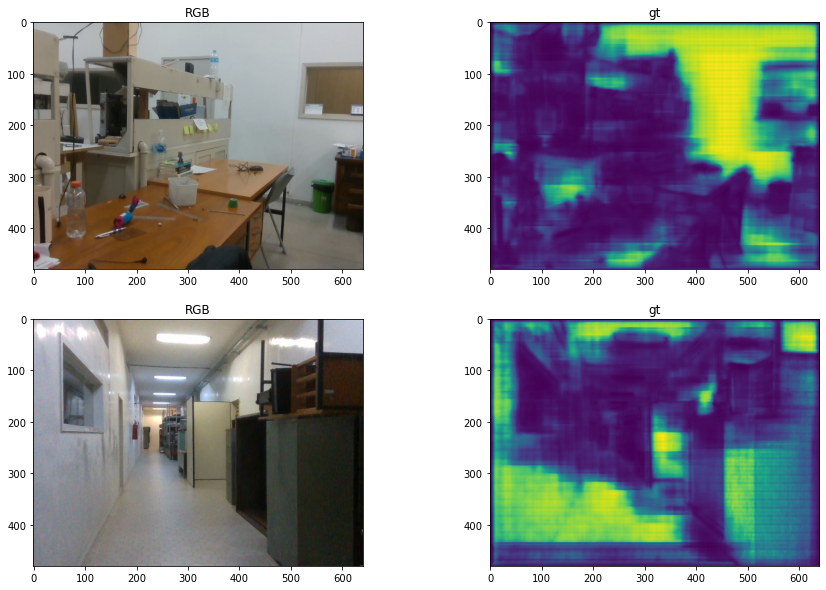

In [37]:
test1 = plt.imread("1.jpg")
test2 = plt.imread("2.jpg")
test1dim = np.expand_dims(test1, axis=0)
test2dim = np.expand_dims(test2, axis=0)
testdim = np.append(test1dim, test2dim, axis=0)
print(testdim.shape)
test_label = unet.predict(testdim, verbose=1)
#test_label = (test_label > 0.5).astype(np.uint8)
plt.subplot(2, 2, 1)
plt.title('RGB')
plt.imshow(test1)
plt.subplot(2, 2, 2)
plt.title('gt')
plt.imshow(test_label[0,:, :, :])
plt.subplot(2, 2, 3)
plt.title('RGB')
plt.imshow(test2)
plt.subplot(2, 2, 4)
plt.title('gt')
plt.imshow(test_label[1,:, :, :])